# Jax vs Scipy Gaussian Filter

This notebook compares the performance and accuracy of the Gaussian filter implemented in JAX and Scipy. Main findings:

- The Gaussian filter shapes agree for all high-order derivatives.
- The boundary handlings agrees for 'constant' and 'wrap', but there is a difference for 'reflect', which needs to be investigated.
- The performance of the Scipy implementation with direct convolution is assumptotically ~3x faster than the JAX implementation. Scaling laws with array size are equivalent. The difference seems to come from the actual convolution implementation.
- However the Jax implementatauon offers a 'fft' method, which makes up for the performance difference especially for large kernel and data sizes.


In [1]:
from jax import numpy as jnp
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.ndimage._filters import _gaussian_kernel1d
from jax.scipy.ndimage import (
    gaussian_filter1d as jax_gaussian_filter1d,
    gaussian_filter as jax_gaussian_filter,
)
from jax._src.scipy.ndimage import _gaussian_kernel1d as jax_gaussian_kernel1d
import matplotlib.pyplot as plt
from functools import partial
import jax
import timeit

## Compare Gaussian Filter Shapes

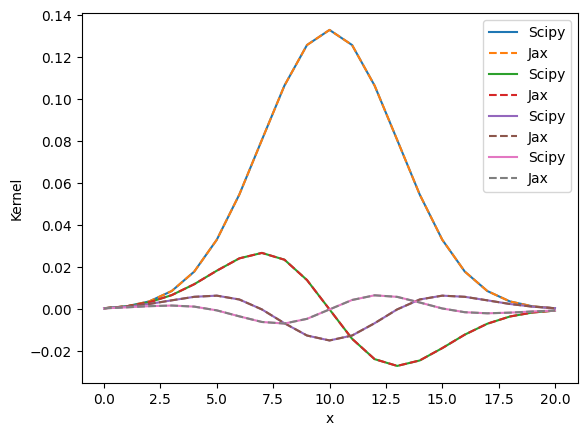

In [2]:
sigma = 3.0

for order in range(4):
    scipy_kernel = _gaussian_kernel1d(sigma, order, radius=10)
    jax_kernel = jax_gaussian_kernel1d(sigma, order, radius=10)

    plt.plot(scipy_kernel, label="Scipy")
    plt.plot(jax_kernel, label="Jax", linestyle="--")

plt.xlabel("x")
plt.ylabel("Kernel")
plt.legend()
plt.show()

## Compare Gaussian Filter Results

## Gaussian Filter 1D

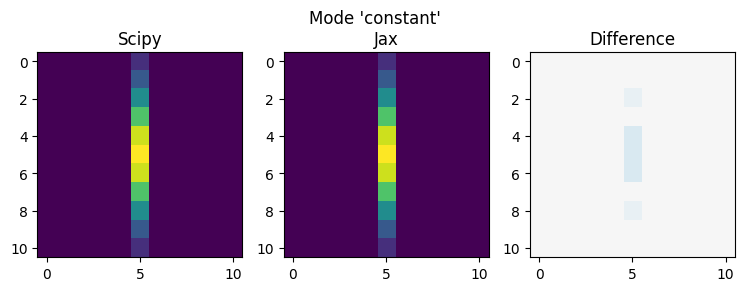

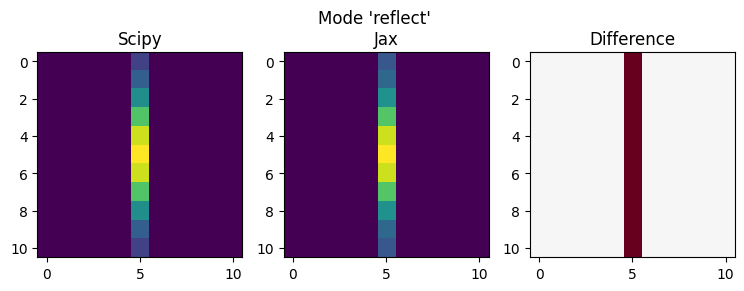

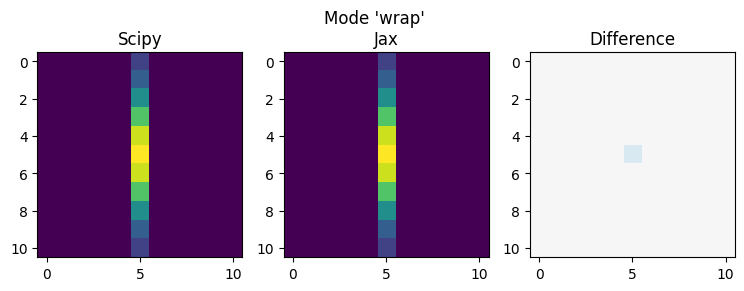

In [3]:
data = jnp.zeros((11, 11))

data = data.at[5, 5].set(1)

sigma =2.5
# scipy_result = gaussian_filter1d(scipy_result, sigma, axis=1)
# jax_result = jax_gaussian_filter1d(jax_result, sigma, axis=1)


for mode in ["constant", "reflect", "wrap"]:
    fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    fig.suptitle(f"Mode '{mode}'")
    scipy_result = gaussian_filter1d(data, sigma, axis=0, mode=mode, cval=0)
    jax_result = jax_gaussian_filter1d(data, sigma, axis=0, mode=mode, cval=0)

    axes[0].imshow(scipy_result)
    axes[1].imshow(jax_result)
    axes[2].imshow((scipy_result - jax_result), cmap="RdBu", vmin=-1e-7, vmax=1e-7)
    axes[0].set_title("Scipy")
    axes[1].set_title("Jax")
    axes[2].set_title("Difference")

plt.show()

## Gaussian Filter 2D

Text(0.5, 1.0, 'Difference')

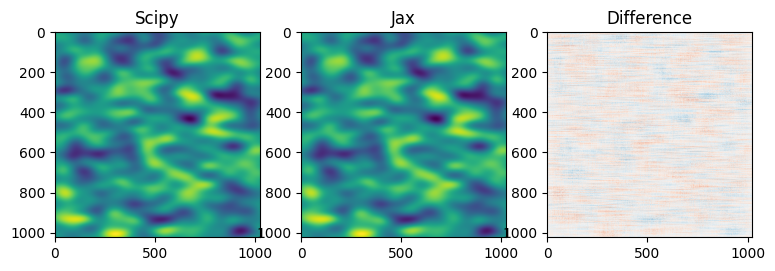

In [4]:
data = jax.random.normal(jax.random.PRNGKey(0), shape=(1024, 1024))

fig, axes = plt.subplots(1, 3, figsize=(9, 3))
scipy_result = gaussian_filter(data, sigma=(22.3, 41.2), mode="constant", cval=0)
jax_result = jax_gaussian_filter(data, sigma=(22.3, 41.2), mode="constant", cval=0)

axes[0].imshow(scipy_result)
axes[1].imshow(jax_result)
axes[2].imshow((scipy_result - jax_result), cmap="RdBu", vmin=-1e-8, vmax=1e-8)
axes[0].set_title("Scipy")
axes[1].set_title("Jax")
axes[2].set_title("Difference")

## Compare Performance Varying Data Size

### Direct Convolution

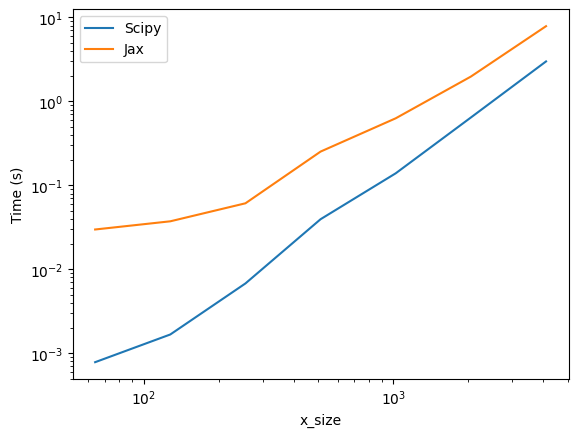

In [5]:
x_sizes = 2 ** jnp.arange(6, 13)
n_iter = 10
sigma = 5.

jax_gaussian_filter1d_jit = jax.jit(jax_gaussian_filter1d, static_argnums=(1, 2, 3, 4))
# trigger compilation
jax_gaussian_filter1d_jit(jnp.zeros((10, 10), dtype=jnp.float32), sigma, axis=0, mode="constant", cval=0)


times_scipy = []
times_jax = []

for x_size in x_sizes:
    data = jax.random.normal(jax.random.PRNGKey(0), shape=(x_size, x_size))
    scipy_time = timeit.timeit(lambda: gaussian_filter1d(data, sigma, axis=0, mode="constant", cval=0), number=n_iter)
    jax_time = timeit.timeit(lambda: jax_gaussian_filter1d_jit(data, sigma, axis=0, mode="constant", cval=0).block_until_ready(), number=n_iter)

    times_scipy.append(scipy_time)
    times_jax.append(jax_time)

plt.plot(x_sizes, times_scipy, label="Scipy")
plt.plot(x_sizes, times_jax, label="Jax")
plt.xlabel("x_size")
plt.ylabel("Time (s)")
plt.loglog()
plt.legend()
plt.show()

### FFT Convolution

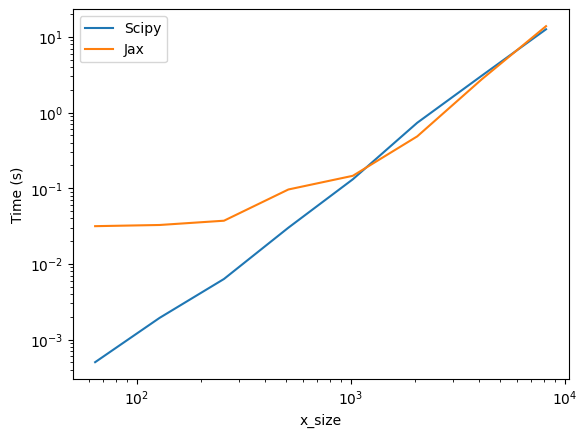

In [6]:
x_sizes = 2 ** jnp.arange(6, 14)
n_iter = 10
sigma = 5.

jax_gaussian_filter1d_jit = jax.jit(jax_gaussian_filter1d, static_argnames=("sigma", "method", "mode", "cval", "truncate", "radius", "axis"))
# trigger compilation
jax_gaussian_filter1d_jit(jnp.zeros((10, 10), dtype=jnp.float32), sigma, axis=0, mode="constant", cval=0, method="fft")

times_scipy = []
times_jax = []

for x_size in x_sizes:
    data = jax.random.normal(jax.random.PRNGKey(0), shape=(x_size, x_size))
    scipy_time = timeit.timeit(lambda: gaussian_filter1d(data, sigma, axis=0, mode="constant", cval=0), number=n_iter)
    jax_time = timeit.timeit(lambda: jax_gaussian_filter1d_jit(data, sigma, axis=0, mode="constant", cval=0, method="fft").block_until_ready(), number=n_iter)

    times_scipy.append(scipy_time)
    times_jax.append(jax_time)

plt.plot(x_sizes, times_scipy, label="Scipy")
plt.plot(x_sizes, times_jax, label="Jax")
plt.xlabel("x_size")
plt.ylabel("Time (s)")
plt.loglog()
plt.legend()
plt.show()

## Compare Performance with Varying Kernel Size

### Direct Convolution


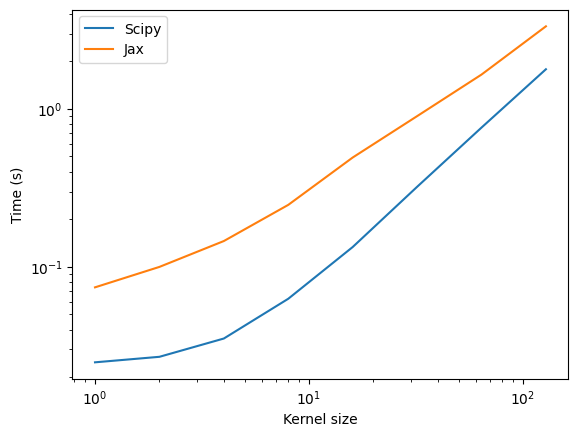

In [7]:
data = jax.random.normal(jax.random.PRNGKey(0), shape=(1024, 1024))
n_iter = 2
kernel_sizes = 2 ** jnp.arange(0, 8)

jax_gaussian_filter_jit = jax.jit(jax_gaussian_filter, static_argnames=("sigma", "method", "mode", "cval", "truncate", "radius"))
# trigger compilation
jax_gaussian_filter_jit(jnp.zeros((10, 10), dtype=jnp.float32), 1., mode="constant", cval=0, method="direct")

times_scipy = []
times_jax = []

for sigma in kernel_sizes:
    scipy_time = timeit.timeit(lambda: gaussian_filter(data, float(sigma), mode="constant", cval=0), number=n_iter)
    jax_time = timeit.timeit(lambda: jax_gaussian_filter_jit(data, float(sigma), mode="constant", cval=0, method="direct").block_until_ready(), number=n_iter)
    times_scipy.append(scipy_time)
    times_jax.append(jax_time)

plt.plot(kernel_sizes, times_scipy, label="Scipy")
plt.plot(kernel_sizes, times_jax, label="Jax")
plt.xlabel("Kernel size")
plt.ylabel("Time (s)")
plt.loglog()
plt.legend()
plt.show()

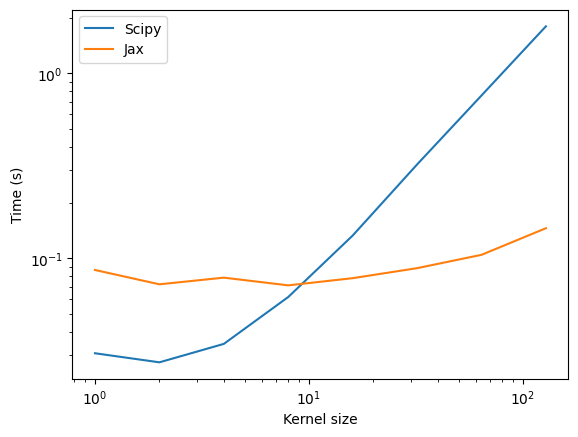

In [8]:
data = jax.random.normal(jax.random.PRNGKey(0), shape=(1024, 1024))
n_iter = 2
kernel_sizes = 2 ** jnp.arange(0, 8)

jax_gaussian_filter_jit = jax.jit(jax_gaussian_filter, static_argnames=("sigma", "method", "mode", "cval", "truncate", "radius"))
# trigger compilation
jax_gaussian_filter_jit(jnp.zeros((10, 10), dtype=jnp.float32), 1., mode="constant", cval=0, method="fft")

times_scipy = []
times_jax = []

for sigma in kernel_sizes:
    scipy_time = timeit.timeit(lambda: gaussian_filter(data, float(sigma), mode="constant", cval=0), number=n_iter)
    jax_time = timeit.timeit(lambda: jax_gaussian_filter_jit(data, float(sigma), mode="constant", cval=0, method="fft").block_until_ready(), number=n_iter)
    times_scipy.append(scipy_time)
    times_jax.append(jax_time)

plt.plot(kernel_sizes, times_scipy, label="Scipy")
plt.plot(kernel_sizes, times_jax, label="Jax")
plt.xlabel("Kernel size")
plt.ylabel("Time (s)")
plt.loglog()
plt.legend()
plt.show()